<a href="https://colab.research.google.com/github/polnops/adiabatic_loading/blob/master/tweezer_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
from scipy.integrate import odeint
import matplotlib.animation as animation
from google.colab import drive
drive.mount('/content/gdrive')

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

IPython_default = plt.rcParams.copy()
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none', 
       labelcolor='white', labelsize = 12,
       axisbelow=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='white')
plt.rc('ytick', direction='out', color='white')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class Harmonic1D(object):
    def __init__(self, n = 1001, t_len = 40):
        
        self.n     = n
        self.t     = np.linspace(-t_len, t_len, n)      
        self.x     = np.empty_like(self.t)
        self.p     = np.empty_like(self.t)   

    # def _model(self, z, t, omega):
    #     x    = z[0]
    #     p    = z[1]
    #     dpdt = -omega**2 *x
    #     dxdt = p
    #     return [dxdt, dpdt] 

    def _model(self, z, t, omega):
        x    = z[0]
        p    = z[1]
        dpdt = 2*(omega**2)*x*np.exp(-(omega*x)**2)
        dxdt = p
        return [dxdt, dpdt]
    
    def _makeTrap(self):
        self.omega = (self.omega_i + self.omega_f)/2.0 \
              - (self.omega_i - self.omega_f)/2.0* \
             np.arctan(self.t/self.tau)/(np.pi/2.0)  

    def solveODE(self, omega_i = 10, omega_f = 1, tau = 10):
        z0        = [0, 0.1]
        self.x[0] = z0[0]
        self.p[0] = z0[1]
        self.omega_i = omega_i
        self.omega_f = omega_f
        self.tau     = tau
        self._makeTrap()
        for i in range(1, self.n):
            tspan = [self.t[i-1], self.t[i]]
            z     = odeint(self._model, z0, tspan, args=(self.omega[i],))
            self.x[i] = z[1][0]
            self.p[i] = z[1][1]
            z0        = z[1]

    def plot_xp(self):

        plt.figure(figsize=(10,2))
        plt.plot(self.t,self.omega,lw=4)
        plt.ylabel('freq')
        plt.xlabel('time')
        plt.figure(figsize=(10,2))
        plt.plot(self.t,self.x,label='x(t)')
        plt.plot(self.t,self.p,label='p(t)')
        plt.ylabel('values')
        plt.xlabel('time')
        plt.legend(loc='best')
        plt.show()
        
    def plot_animation(self, savepath = 'adia1d.mp4'):
    
        fig = plt.figure()
        ax = plt.axes(xlim=(-2, 2), ylim=(-10, 0))
        line, = ax.plot([], [], lw=3)
        line2, = ax.plot([], [], marker='o',linestyle='None',markersize=12)

        def animate(i):

            xplot = np.linspace(-2,2,100)
            # line.set_data(xplot, (self.omega[i]*xplot)**2)
            # line2.set_data(self.x[i],(self.omega[i]*self.x[i])**2)

            line.set_data(xplot, -np.exp(-(self.omega[i]*xplot)**2))
            line2.set_data(self.x[i], -np.exp(-(self.omega[i]*self.x[i])**2))
            return line, line2

        anim = animation.FuncAnimation(fig, animate, frames=self.n, 
                                        interval=20, blit=True)
        anim.save(savepath)

        plt.show()

In [0]:
class Adiabaticity1D(Harmonic1D):
    def __init__(self, n = 1001, t_len = 40):

        super(Adiabaticity1D, self).__init__(n, t_len)
        
    def _strided_app(self, a, window_len, stride):  
        nrows = ((a.size-window_len)//stride)+1
        n = a.strides[0]
        return np.lib.stride_tricks.as_strided(a, shape=(nrows,window_len), 
                                               strides=(stride*n,n))

    def phasespaceVol(self, t_window = 30, stride = 5):
        self.t_sampled = np.mean(self._strided_app(self.t,t_window,stride),axis=1)
        self.dx = np.std(self._strided_app(self.x,t_window,stride),axis=1)
        self.dp = np.std(self._strided_app(self.p,t_window,stride),axis=1)
        self.dV = self.dx*self.dp
    
    def plotvoltrace(self):
        self.phasespaceVol(t_window = 40, stride = 3)
        plt.figure(figsize=(10,2))
        plt.plot(self.t_sampled,self.dx,'g-',label='dx',lw=4)
        plt.plot(self.t_sampled,self.dp,'b-',label='dp')
        plt.plot(self.t_sampled,self.dV/max(self.dV),'r--',label='phase space vol')
        plt.ylabel('values')
        plt.xlabel('time')
        plt.legend(loc='best')
        plt.show()
        plt.show()
        
    def adiabaticityMap(self, n = 50, power_min = -1, power_max = 3):

        adia2d = []
        tau_list = 10**np.linspace(power_min, power_max,n)
        
        for tau0 in tau_list:
            self.solveODE(tau = tau0)
            self.phasespaceVol(t_window = 40, stride = 3)
            adia2d.append([self.dx,self.dp,self.dV])

        self.adiabaticmap = np.array(adia2d)[:,2,:]

        x,y = np.meshgrid(adia.t_sampled, tau_list)
        m,n = np.shape(self.adiabaticmap)

        plt.pcolormesh(x,y,self.adiabaticmap)
        plt.yscale('log',basey=10)
        plt.ylabel("tau")
        plt.xlabel("time")
        plt.colorbar()
        plt.show()


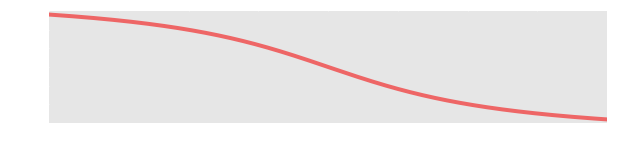

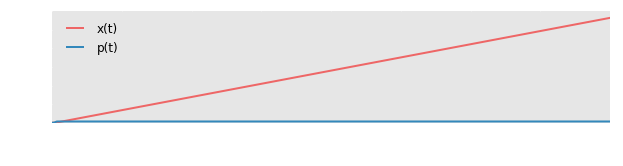

In [5]:
h1d = Harmonic1D()
h1d.solveODE(omega_i = 5, omega_f = 1, tau = 20)
h1d.plot_xp()


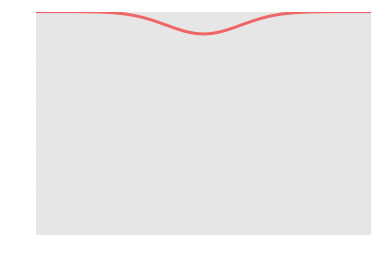

In [6]:
path = '/content/gdrive/My Drive/Atom_cavity/personal folders/Po/adiabatic_cooling'
os.chdir(path)
h1d.plot_animation(savepath = 'gaussian.mp4')

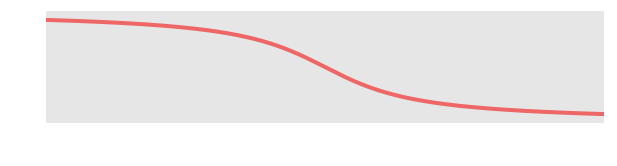

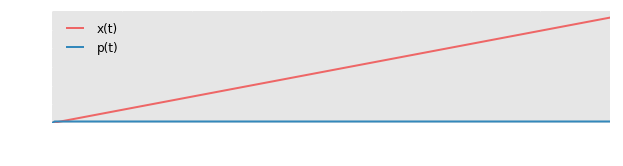

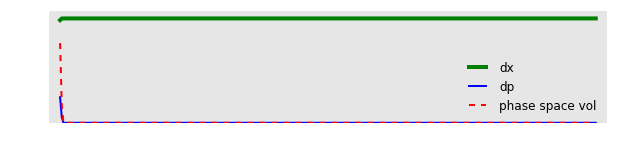

In [7]:
adia = Adiabaticity1D()
adia.solveODE(tau = 10)
adia.plot_xp()
adia.plotvoltrace()

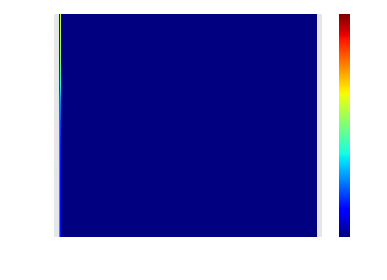

In [8]:
adia.adiabaticityMap()